In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import load_mnist
#from keras.datasets import mnist

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 1000x750 with 0 Axes>

In [2]:
# read MNIST data set and scale it
X0,y0,Xv,yv,X1,y1 = load_mnist.read([0,1,2,3,4,5,6,7,8,9], path="")
x0 = (1.0/255.0)*X0.astype('float64')
x1 = (1.0/255.0)*X1.astype('float64')
x2 = (1.0/255.0)*Xv.astype('float64')
y0 = y0.astype('float64')
y1 = y1.astype('float64')
y2 = yv.astype('float64')

MNIST, Classes:     10
Training Images:    (50000, 784)
Validation Images:  (10000, 784)
Test Images:        (10000, 784)


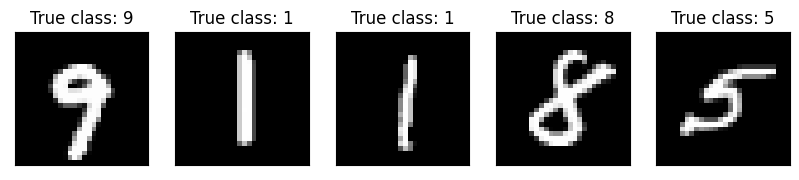

In [3]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

subsample = np.random.permutation(x0.shape[0])[:5]
images = x0[subsample]
labels = ['True class: %d' % np.argmax(l) for l in y0[subsample]]
plot_gallery(images, labels, shape=(28, 28))

Globale Arrays und Variablen des Netzwerkes:

In [4]:
# Netzwerkparameter
#mbs = 10                     # Größe der Minibatches
mbs = 10
#eta = 3.0                    # Lernrate
#eta = 0.03
eta = 1.0
#no_hidden = 36               # Anzahl versteckter Neuronen
no_hidden = 2
#epochs = 15                  # Anzahl Epochen
epochs = 150
#sizes = [784, no_hidden, 10] # dreischichtiges MPL mit 784 Eingangs-, no_hidden versteckten, 10 Ausgangsneuronen
sizes = [2, no_hidden, no_hidden, 1]
num_layers = len(sizes)      # Anzahl Schichten
costs = []

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[0].shape)
print(weights[1].shape)


(2, 2)
(2, 2)


Einige Hilfsfunktionen:

In [5]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
    #return np.tanh(z)

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))
    #return 1 - np.square(np.tanh(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    #return (output_activations-y)
    return (np.nan_to_num(-((output_activations - y) / ((output_activations - 1) * output_activations))))

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [6]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [7]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [8]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [9]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    squared_errors = []
    logistic_costs = []
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Label ist in one-hot-Codierung: korrekte Klasse ist 1, alle anderen 0
        #c = np.argmax(y)

        # Label ist nicht in one-hot-Codierung: Klasse entspricht der Kodierung
        c = y

        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        #cpred = np.argmax(ypred)
        cpred = ypred

        # Für Sigmoid
        if(c == 0):
            if cpred < 0.5:
                correct += 1

        if(c == 1):
            if cpred > 0.5:
                correct += 1
        

        # Für tanh (Aufgabe 3)
        """ if (c == 0):
            if (cpred < 0):
                correct += 1
        if (c == 1):
            if (cpred > 0):
                correct += 1 """

        #squared_errors.append(np.square(c - cpred))

        logistic_costs.append(np.nan_to_num(- c * np.log(cpred) - (1 - c) * np.log(1 - cpred)))
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        #if c == cpred:
        #    correct += 1
    
    #costs.append(np.mean(squared_errors))
    costs.append(np.mean(logistic_costs))
    return correct

Stochastischer Gradientenabstieg:

In [10]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j] = evaluate(x2, y2)
        print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))
    
    return acc_val

Training:

In [11]:
#acc_val = SGD(x0, y0, epochs, mbs, eta, x2, y2)

Evaluation auf den unabhängigen Testdaten:

In [12]:
#print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

Lernkurve (Genauigkeit auf Validierungsdatensatz):

In [13]:
#plt.plot(acc_val/x2.shape[0])

Trainierte rezeptive Felder:

In [14]:
#labels = range(no_hidden)
#plot_gallery(weights[0][:10,:],labels, shape=(28, 28))

In [15]:
#labels = range(10)
#plot_gallery(weights[1],labels, shape=(36,1))

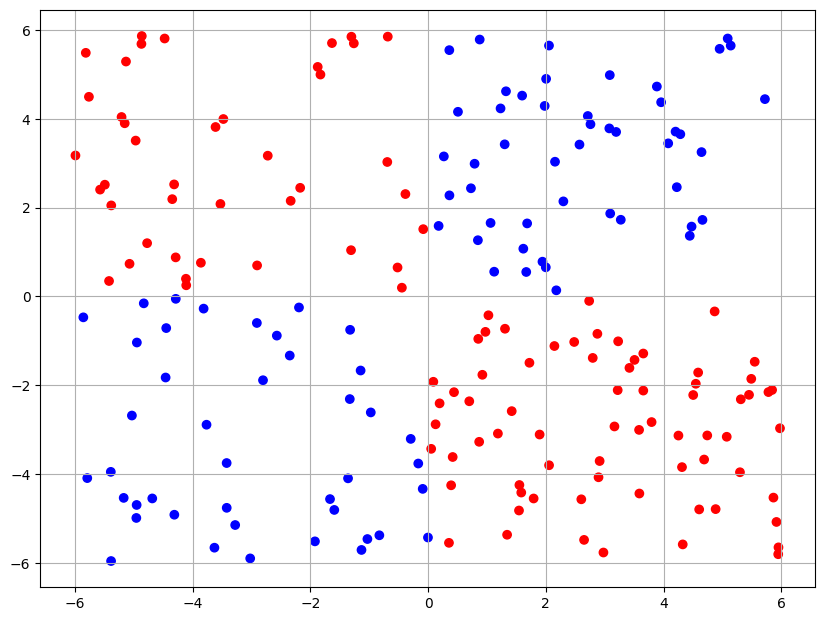

In [16]:
# Erstes Aufgabenblatt:
import pandas as pd
import matplotlib.pyplot as plt
train = np.array([np.random.uniform(-6.0, 6.0, 200), np.random.uniform(-6.0, 6.0, 200)]).T
df_train = pd.DataFrame(train)
df_train['labels'] = np.where((df_train[0] > 0) & (df_train[1] > 0) | (df_train[0] < 0) & (df_train[1] < 0) , 1, 0)
colors = np.where(df_train['labels'] == 1, 'blue', 'red')
plt.scatter(df_train[0], df_train[1], c = colors)


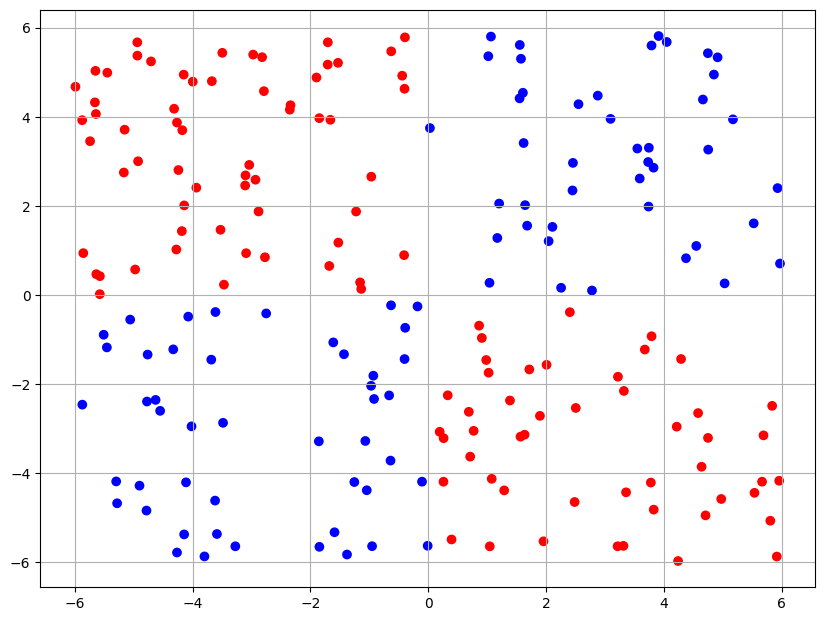

In [17]:
test = np.array([np.random.uniform(-6.0, 6.0, 200), np.random.uniform(-6.0, 6.0, 200)]).T
df_test = pd.DataFrame(test)
df_test['labels'] = np.where((df_test[0] > 0) & (df_test[1] > 0) | (df_test[0] < 0) & (df_test[1] < 0) , 1, 0)
colors = np.where(df_test['labels'] == 1, 'blue', 'red')
plt.scatter(df_test[0], df_test[1], c = colors)

In [18]:
# Aufgabe 1.4
w_ver = np.array([0, 1])
w_hor = np.array([1, 0])

In [19]:
# Aufgabe 1.5
a_hor = []
a_ver = []
for x in np.arange(-6, 6, 0.12):
    for y in np.arange(-6, 6, 0.12):
        a_hor.append(sigmoid(np.dot(w_hor, (x, y))))
        a_ver.append(sigmoid(np.dot(w_ver, (x, y))))
a_hor = np.array(a_hor)
a_ver = np.array(a_ver)

C:\Users\malte\AppData\Local\Temp\ipykernel_7752\778741606.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(X, Y, np.reshape(a_hor, (100, 100)), cmap='viridis')
C:\Users\malte\AppData\Local\Temp\ipykernel_7752\778741606.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


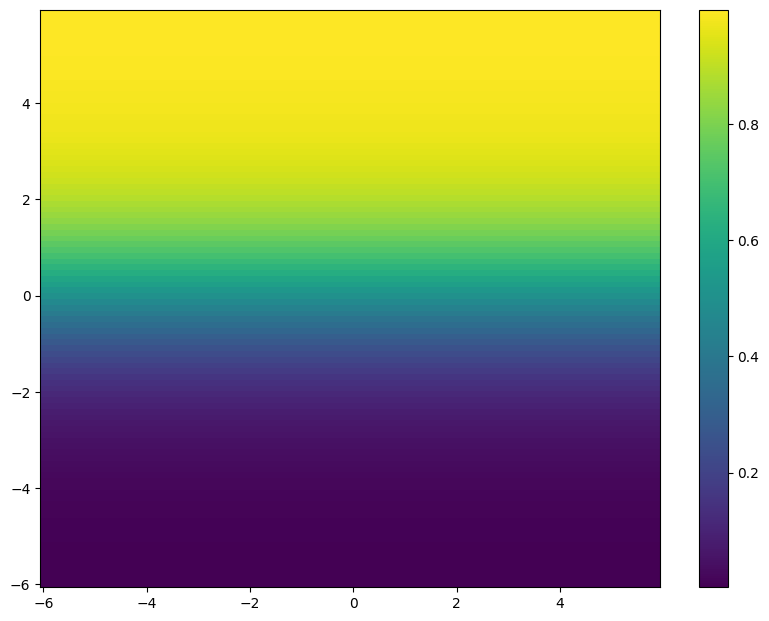

In [20]:
X,Y = np.meshgrid(np.arange(-6, 6, 0.12), np.arange(-6, 6, 0.12))
plt.pcolor(X, Y, np.reshape(a_hor, (100, 100)), cmap='viridis')
plt.colorbar()
plt.show()

C:\Users\malte\AppData\Local\Temp\ipykernel_7752\414951029.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(X, Y, np.reshape(a_ver, (100, 100)), cmap='viridis')
C:\Users\malte\AppData\Local\Temp\ipykernel_7752\414951029.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


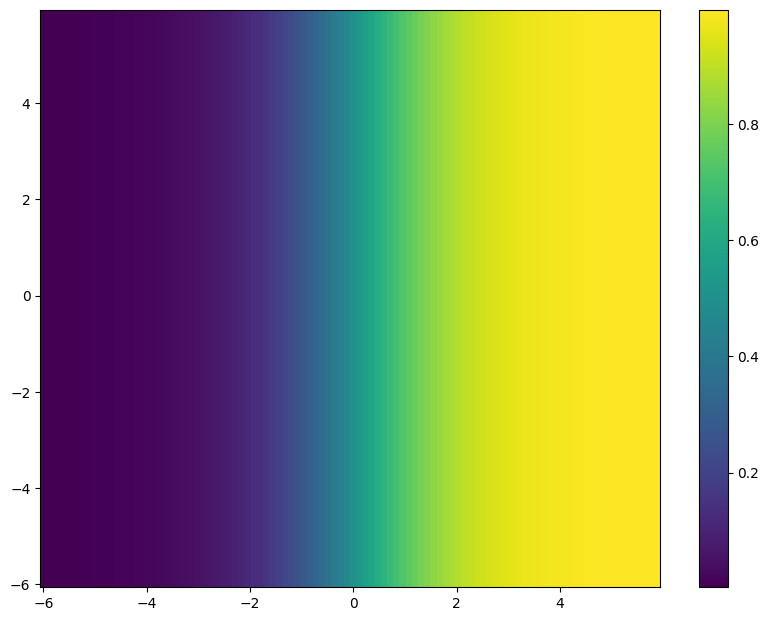

In [21]:
X,Y = np.meshgrid(np.arange(-6, 6, 0.12), np.arange(-6, 6, 0.12))
plt.pcolor(X, Y, np.reshape(a_ver, (100, 100)), cmap='viridis')
plt.colorbar()
plt.show()

In [22]:
# Berechne Designmatrizen für Trainings- und Testdaten
X_train = np.stack((sigmoid(np.dot(train, w_hor)), sigmoid(np.dot(train, w_ver))), axis = 1)
X_test = np.stack((sigmoid(np.dot(test, w_hor)), sigmoid(np.dot(test, w_ver))), axis = 1)

In [23]:
# Berechne Designmatrix für Gitter
X_grid = np.array(np.stack((a_hor, a_ver), axis = 1))

In [24]:
costs = []
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
# initialisere Trainingsdaten
x0 = X_train
y0 = df_train['labels'].to_numpy()

# initialisere Validierungsdaten
x1 = X_train
y1 = df_train['labels'].to_numpy()

# initialisere Testdaten
x2 = X_test
y2 = df_test['labels'].to_numpy()

acc_val = SGD(x0, y0, epochs, mbs, eta, x2, y2)

Epoch 0: 110.0 / 200
Epoch 1: 110.0 / 200
Epoch 2: 90.0 / 200
Epoch 3: 110.0 / 200
Epoch 4: 90.0 / 200
Epoch 5: 110.0 / 200
Epoch 6: 90.0 / 200
Epoch 7: 90.0 / 200
Epoch 8: 110.0 / 200
Epoch 9: 110.0 / 200
Epoch 10: 110.0 / 200
Epoch 11: 93.0 / 200
Epoch 12: 110.0 / 200
Epoch 13: 110.0 / 200
Epoch 14: 102.0 / 200
Epoch 15: 110.0 / 200
Epoch 16: 110.0 / 200
Epoch 17: 110.0 / 200
Epoch 18: 124.0 / 200
Epoch 19: 110.0 / 200
Epoch 20: 80.0 / 200
Epoch 21: 112.0 / 200
Epoch 22: 126.0 / 200
Epoch 23: 85.0 / 200
Epoch 24: 86.0 / 200
Epoch 25: 132.0 / 200
Epoch 26: 125.0 / 200
Epoch 27: 135.0 / 200
Epoch 28: 124.0 / 200
Epoch 29: 133.0 / 200
Epoch 30: 115.0 / 200
Epoch 31: 129.0 / 200
Epoch 32: 133.0 / 200
Epoch 33: 134.0 / 200
Epoch 34: 128.0 / 200
Epoch 35: 132.0 / 200
Epoch 36: 130.0 / 200
Epoch 37: 134.0 / 200
Epoch 38: 132.0 / 200
Epoch 39: 78.0 / 200
Epoch 40: 134.0 / 200
Epoch 41: 110.0 / 200
Epoch 42: 134.0 / 200
Epoch 43: 107.0 / 200
Epoch 44: 133.0 / 200
Epoch 45: 133.0 / 200
Epoch 4

In [25]:
print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

Test accuracy: 190 / 200


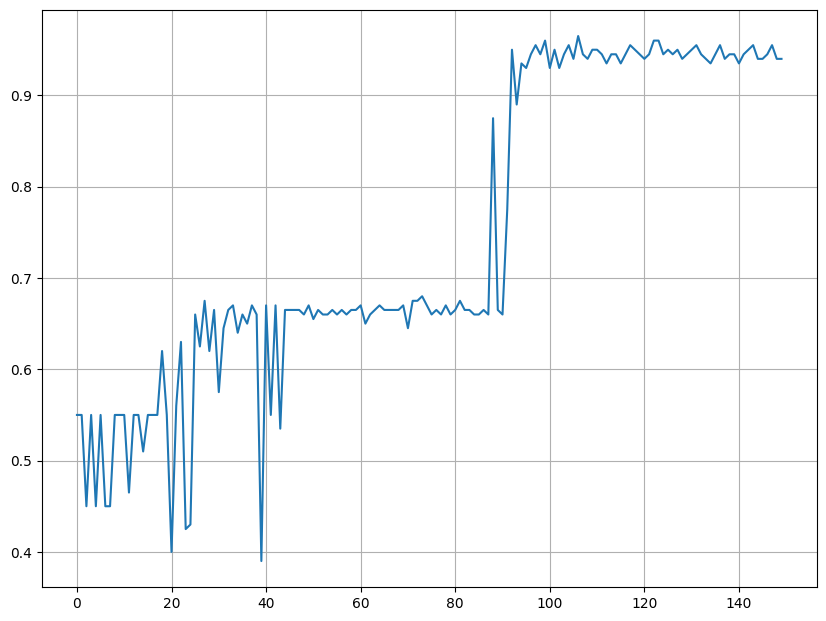

In [26]:
plt.plot(acc_val/x2.shape[0])

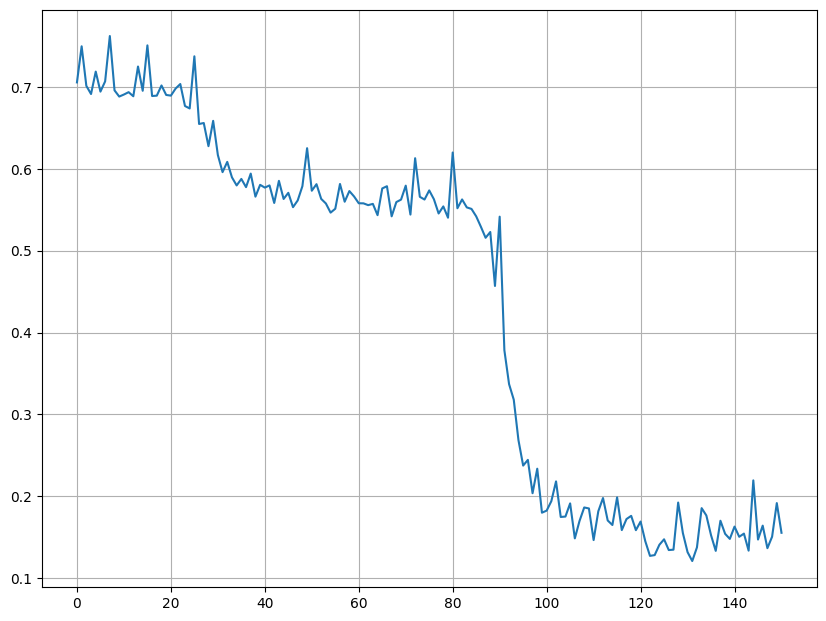

In [27]:
plt.plot(costs)

In [28]:
grid_nn_output = feedforward(X_grid.T)

C:\Users\malte\AppData\Local\Temp\ipykernel_7752\3883989180.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(X, Y, np.reshape(grid_nn_output, (100, 100)), cmap='viridis')
C:\Users\malte\AppData\Local\Temp\ipykernel_7752\3883989180.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


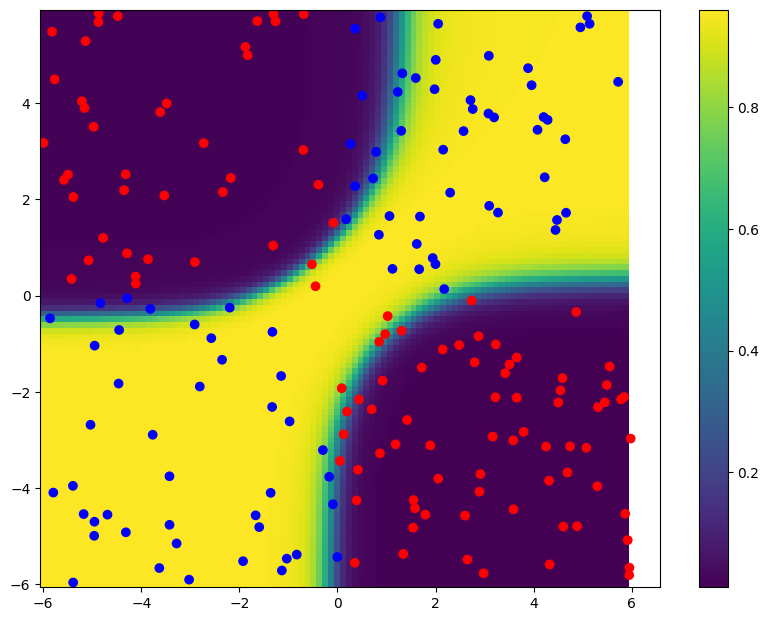

In [29]:
X,Y = np.meshgrid(np.arange(-6, 6, 0.12), np.arange(-6, 6, 0.12))
plt.pcolor(X, Y, np.reshape(grid_nn_output, (100, 100)), cmap='viridis')
plt.colorbar()
colors = np.where(df_train['labels'] == 1, 'blue', 'red')
plt.scatter(df_train[0], df_train[1], c = colors)
plt.show()